Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
numero total de paises (internet): 194

Varianza explicada por cada componente (internet): [0.73941428 0.24063285]
Varianza explicada acumulada (internet): [0.73941428 0.98004712]


/tmp/ipython-input-243252480.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill", axis=1) \
/tmp/ipython-input-243252480.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="bfill", axis=1)


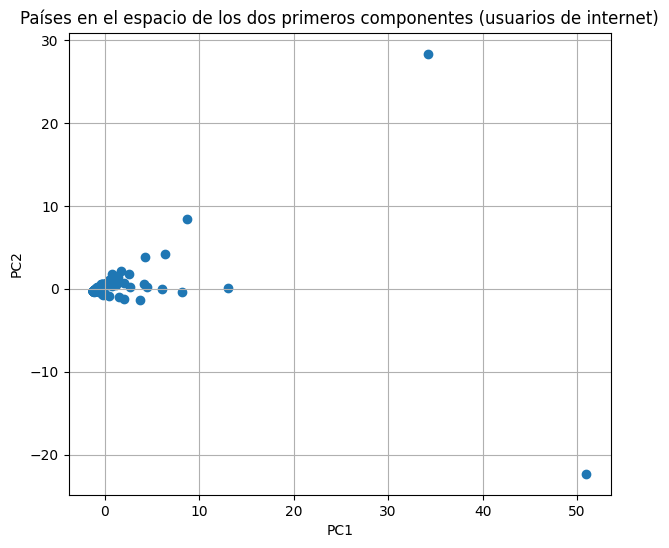

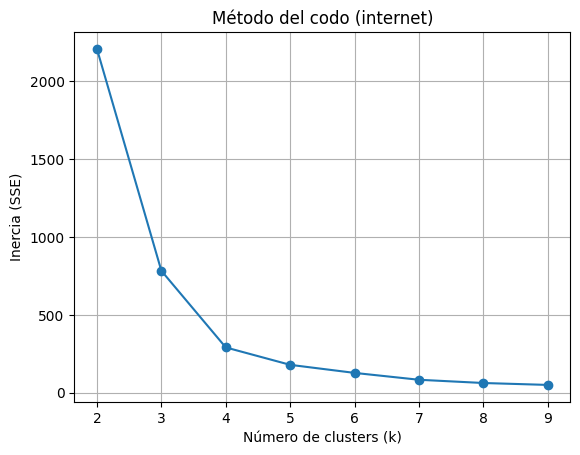

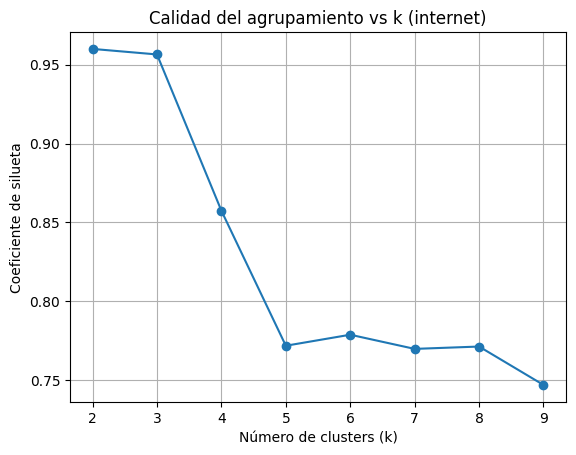

Filas pivot_internet: 194
Len cluster_labels_int: 194


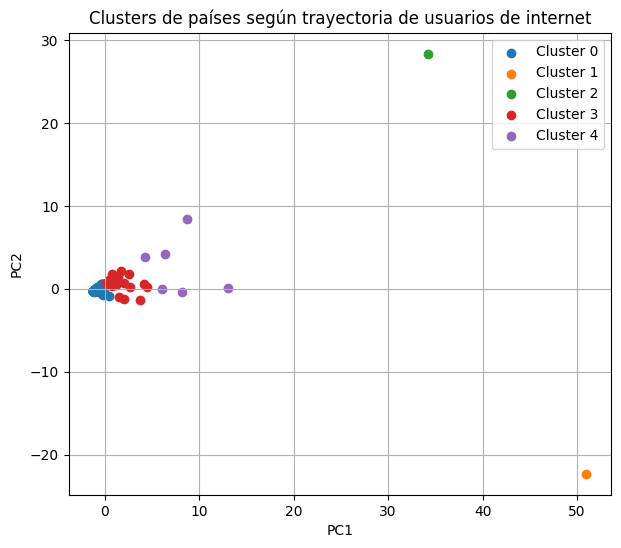

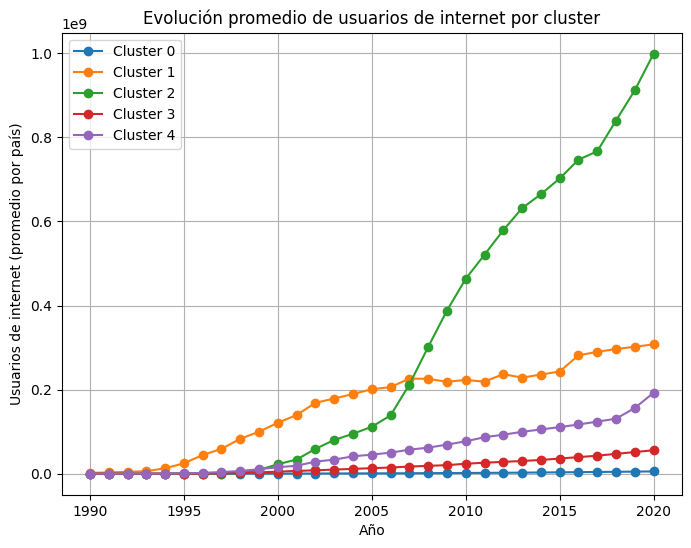


Cluster 0 (n=164):
 - Afghanistan
 - Albania
 - Algeria
 - Andorra
 - Angola
 - Antigua and Barbuda
 - Armenia
 - Aruba
 - Austria
 - Azerbaijan
 - Bahamas
 - Bahrain
 - Bangladesh
 - Barbados
 - Belarus
 - Belgium
 - Belize
 - Benin
 - Bermuda
 - Bhutan
 - Bolivia
 - Bosnia and Herzegovina
 - Botswana
 - Brunei
 - Bulgaria
 - Burkina Faso
 - Burundi
 - Cambodia
 - Cameroon
 - Cape Verde
 - Central African Republic
 - Chad
 - Chile
 - Comoros
 - Congo
 - Costa Rica
 - Cote d'Ivoire
 - Croatia
 - Cuba
 - Cyprus
 - Czechia
 - Democratic Republic of Congo
 - Denmark
 - Djibouti
 - Dominica
 - Dominican Republic
 - East Timor
 - Ecuador
 - El Salvador
 - Equatorial Guinea
 - Eritrea
 - Estonia
 - Eswatini
 - Ethiopia
 - Fiji
 - Finland
 - French Polynesia
 - Gabon
 - Gambia
 - Georgia
 - Ghana
 - Greece
 - Greenland
 - Grenada
 - Guam
 - Guatemala
 - Guinea
 - Guinea-Bissau
 - Guyana
 - Haiti
 - Honduras
 - Hong Kong
 - Hungary
 - Iceland
 - Iraq
 - Ireland
 - Israel
 - Jamaica
 - Jordan


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# ============================
# 1. Cargar datos INTERNET
# ============================
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/PROYECTO CIENCIA DE DATOS/number-of-internet-users.csv"
df_internet = pd.read_csv(data_path)

# Eliminar "World"
df_internet = df_internet[df_internet["Entity"] != "World"]

# Solo países (Code no nulo)
df_countries = df_internet[df_internet["Code"].notna()].copy()

# Rango de años de interés
year_min, year_max = 1990, 2020
mask_years = (df_countries["Year"] >= year_min) & (df_countries["Year"] <= year_max)
df_countries = df_countries[mask_years]

# ============================
# 2. Pivot: filas=país, columnas=años
# ============================
pivot_internet = df_countries.pivot(
    index="Entity",
    columns="Year",
    values="Number of Internet users"
)

# Eliminar países con más del 20% de años faltantes
max_missing_ratio = 0.2
mask_rows = pivot_internet.isna().mean(axis=1) <= max_missing_ratio
pivot_internet = pivot_internet[mask_rows].copy()

# Interpolación temporal por país y relleno de extremos
pivot_internet = pivot_internet.interpolate(axis=1) \
                                 .fillna(method="ffill", axis=1) \
                                 .fillna(method="bfill", axis=1)

# ============================
# 3. Matriz de características
# ============================
countries = pivot_internet.index.to_list()
years_internet = pivot_internet.columns.to_list()
X = pivot_internet.values  # shape: (n_paises, m_years)
print(f"numero total de paises (internet): {len(countries)}\n")

# Estandarización
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# ============================
# 4. PCA
# ============================
pca_int = PCA(n_components=2)
X_pca_int = pca_int.fit_transform(X_std)

print("Varianza explicada por cada componente (internet):", pca_int.explained_variance_ratio_)
print("Varianza explicada acumulada (internet):", pca_int.explained_variance_ratio_.cumsum())

# Gráfica del PCA (sin clusters todavía)
plt.figure(figsize=(7, 6))
plt.scatter(X_pca_int[:, 0], X_pca_int[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Países en el espacio de los dos primeros componentes (usuarios de internet)")
plt.grid(True)
plt.show()

# ============================
# 5. Elección de k (codo + silueta)
# ============================
inertias = []
silhouettes = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=123, n_init=10)
    labels = km.fit_predict(X_pca_int)
    inertias.append(km.inertia_)
    sil_score = silhouette_score(X_pca_int, labels)
    silhouettes.append(sil_score)

# Método del codo
plt.figure()
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (SSE)")
plt.title("Método del codo (internet)")
plt.grid(True)
plt.show()

# Coeficiente de silueta
plt.figure()
plt.plot(K_range, silhouettes, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Coeficiente de silueta")
plt.title("Calidad del agrupamiento vs k (internet)")
plt.grid(True)
plt.show()

# ============================
# 6. Clustering final
# ============================
k_opt_int = 5
kmeans_int = KMeans(n_clusters=k_opt_int, random_state=123, n_init=10)
cluster_labels_int = kmeans_int.fit_predict(X_pca_int)

# coinciden las longitudes:
print("Filas pivot_internet:", pivot_internet.shape[0])
print("Len cluster_labels_int:", len(cluster_labels_int))

pivot_internet["cluster_internet"] = cluster_labels_int

# Visualización de clusters en el plano de PCA
plt.figure(figsize=(7, 6))
for c in range(k_opt_int):
    mask = pivot_internet["cluster_internet"] == c
    plt.scatter(
        X_pca_int[mask, 0],
        X_pca_int[mask, 1],
        label=f"Cluster {c}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters de países según trayectoria de usuarios de internet")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 7. Resumen de clusters
# ============================

cluster_means_int = pivot_internet.groupby("cluster_internet")[years_internet].mean()

plt.figure(figsize=(8, 6))
for c in range(k_opt_int):
    plt.plot(
        years_internet,
        cluster_means_int.loc[c],
        marker="o",
        label=f"Cluster {c}"
    )

plt.xlabel("Año")
plt.ylabel("Usuarios de internet (promedio por país)")
plt.title("Evolución promedio de usuarios de internet por cluster")
plt.legend()
plt.grid(True)
plt.show()

for c in range(k_opt_int):
    subset = pivot_internet[pivot_internet["cluster_internet"] == c]
    print(f"\nCluster {c} (n={len(subset)}):")
    for country in subset.index:
        print(" -", country)


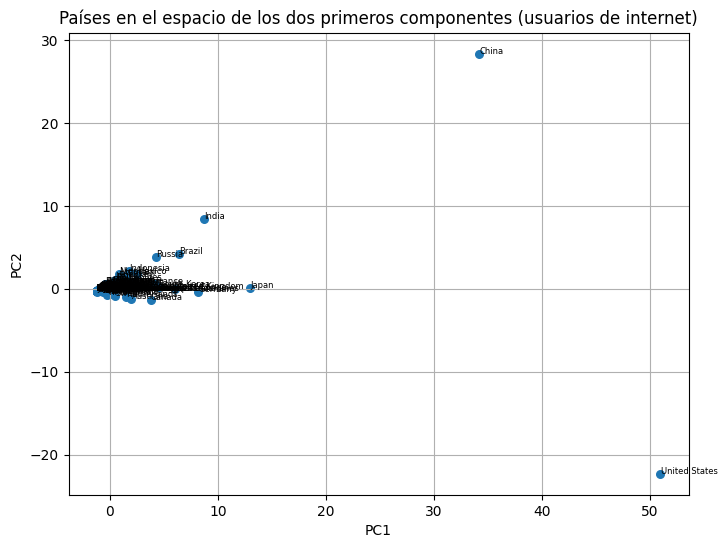

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca_int[:,0], X_pca_int[:,1], s=30)

for i, country in enumerate(countries):
    plt.text(X_pca_int[i,0] + 0.02, X_pca_int[i,1] + 0.02, country, fontsize=6)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Países en el espacio de los dos primeros componentes (usuarios de internet)")
plt.grid(True)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total de países usados: 237
Varianza explicada PC1 y PC2: [0.95015788 0.0271453 ]
Varianza explicada acumulada: [0.95015788 0.97730318]


/tmp/ipython-input-2569986717.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill", axis=1) \
/tmp/ipython-input-2569986717.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="bfill", axis=1)


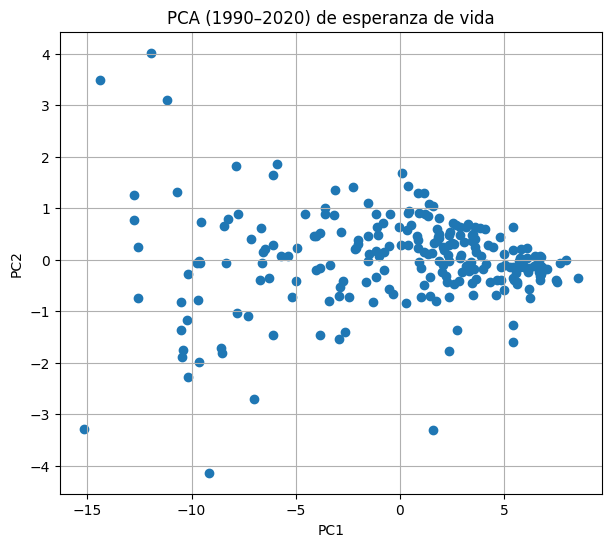

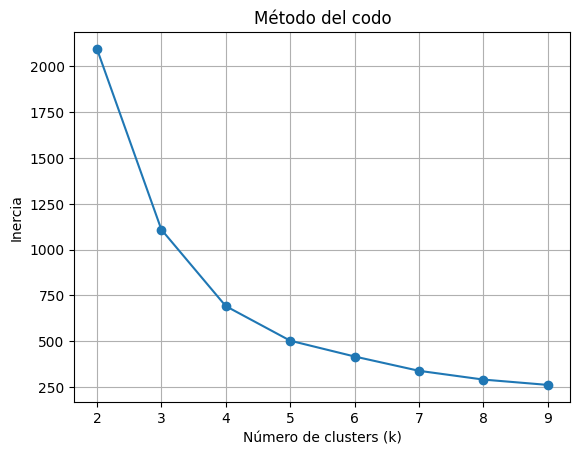

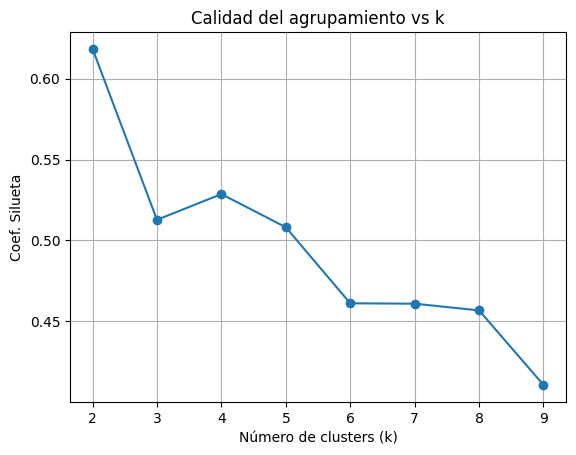

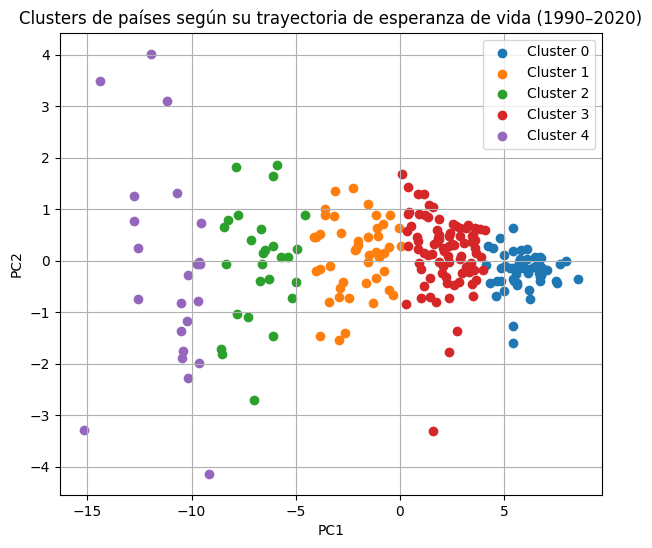

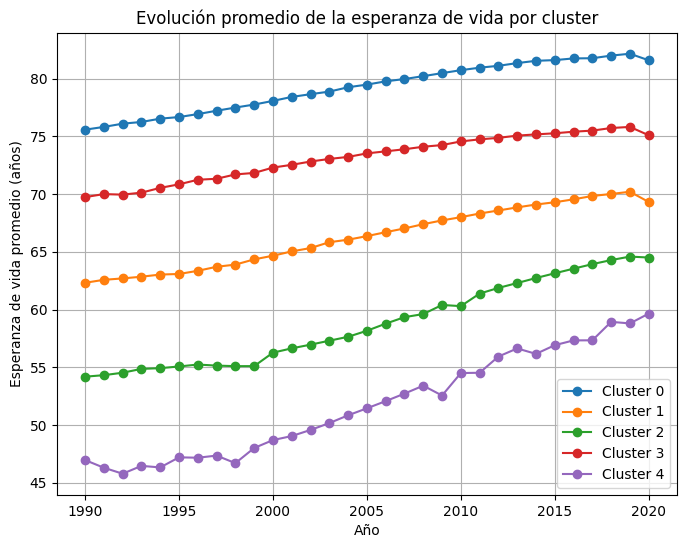


Cluster 0 (n=58):
 - Albania
 - Andorra
 - Australia
 - Austria
 - Bahrain
 - Belgium
 - Bermuda
 - Canada
 - Chile
 - Costa Rica
 - Cuba
 - Cyprus
 - Denmark
 - Faroe Islands
 - Finland
 - France
 - French Polynesia
 - Germany
 - Gibraltar
 - Greece
 - Guadeloupe
 - Guernsey
 - Hong Kong
 - Iceland
 - Ireland
 - Isle of Man
 - Israel
 - Italy
 - Japan
 - Jersey
 - Kuwait
 - Liechtenstein
 - Luxembourg
 - Macao
 - Malta
 - Martinique
 - Monaco
 - Netherlands
 - New Zealand
 - Norway
 - Portugal
 - Puerto Rico
 - Qatar
 - Reunion
 - Saint Barthelemy
 - Saint Martin (French part)
 - San Marino
 - Singapore
 - Slovenia
 - South Korea
 - Spain
 - Sweden
 - Switzerland
 - Taiwan
 - United Arab Emirates
 - United Kingdom
 - United States
 - Vatican

Cluster 1 (n=45):
 - Azerbaijan
 - Bangladesh
 - Bhutan
 - Bolivia
 - Cambodia
 - Egypt
 - El Salvador
 - Fiji
 - Gabon
 - Greenland
 - Guatemala
 - Guyana
 - Honduras
 - India
 - Indonesia
 - Iraq
 - Kazakhstan
 - Kiribati
 - Kyrgyzstan
 - Mars

In [26]:
# ============================
# 1. Cargar datos
# ============================
drive.mount('/content/drive')

# ACTUALIZA ESTA RUTA si tu CSV está en otra carpeta
data_path = "/content/drive/MyDrive/PROYECTO CIENCIA DE DATOS/life-expectancy.csv"
df_life = pd.read_csv(data_path)

# Renombrar columna
df_life = df_life.rename(columns={"Period life expectancy at birth": "life_expectancy"})

# Quitar entradas sin código y "World"
df_life = df_life[df_life["Code"].notna()]
df_life = df_life[df_life["Entity"] != "World"]

# Filtrar años 1990–2020
year_min, year_max = 1990, 2020
mask = (df_life["Year"] >= year_min) & (df_life["Year"] <= year_max)
df_life = df_life[mask].copy()

# ============================
# 2. Pivot país × año
# ============================
pivot_life = df_life.pivot(
    index="Entity",
    columns="Year",
    values="life_expectancy"
)

# ============================
# 3. Filtrar países con demasiados NaN
# ============================
max_missing_ratio = 0.20
mask_rows = pivot_life.isna().mean(axis=1) <= max_missing_ratio
pivot_life = pivot_life[mask_rows].copy()

# Interpolar temporalmente por país
pivot_life = pivot_life.interpolate(axis=1) \
               .fillna(method="ffill", axis=1) \
               .fillna(method="bfill", axis=1)

countries = pivot_life.index.to_list()
years = pivot_life.columns.to_list()
pivot_cluster = pivot_life.copy()
X = pivot_cluster.values

print(f"Total de países usados: {len(countries)}")

# ============================
# 4. Estandarización
# ============================
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# ============================
# 5. PCA (dos componentes)
# ============================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

print("Varianza explicada PC1 y PC2:", pca.explained_variance_ratio_)
print("Varianza explicada acumulada:", pca.explained_variance_ratio_.cumsum())

plt.figure(figsize=(7, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (1990–2020) de esperanza de vida")
plt.grid(True)
plt.show()

# ============================
# 6. Elección de k (codo + silueta)
# ============================
inertias = []
silhouettes = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=123, n_init=10)
    labels = km.fit_predict(X_pca)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_pca, labels))

plt.figure()
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(K_range, silhouettes, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Coef. Silueta")
plt.title("Calidad del agrupamiento vs k")
plt.grid(True)
plt.show()

# ============================
# 7. Clustering final
# ============================
k_opt = 5  # AJUSTAR según codo+silueta
kmeans = KMeans(n_clusters=k_opt, random_state=123, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

pivot_life["cluster"] = cluster_labels

# Visualización final PC1–PC2
plt.figure(figsize=(7, 6))
for c in range(k_opt):
    mask = pivot_life["cluster"] == c
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=f"Cluster {c}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters de países según su trayectoria de esperanza de vida (1990–2020)")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 8. Evolución promedio por cluster
# ============================
cluster_means = pivot_life.groupby("cluster")[years].mean()

plt.figure(figsize=(8, 6))
for c in range(k_opt):
    plt.plot(
        years,
        cluster_means.loc[c],
        marker="o",
        label=f"Cluster {c}"
    )

plt.xlabel("Año")
plt.ylabel("Esperanza de vida promedio (años)")
plt.title("Evolución promedio de la esperanza de vida por cluster")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 9. Lista de países por cluster
# ============================
for c in range(k_opt):
    subset = pivot_life[pivot_life["cluster"] == c]
    print(f"\nCluster {c} (n={len(subset)}):")
    for country in subset.index:
        print(" -", country)


**Unificación de ambos datasets para CORRELACIONES**

Años en común: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


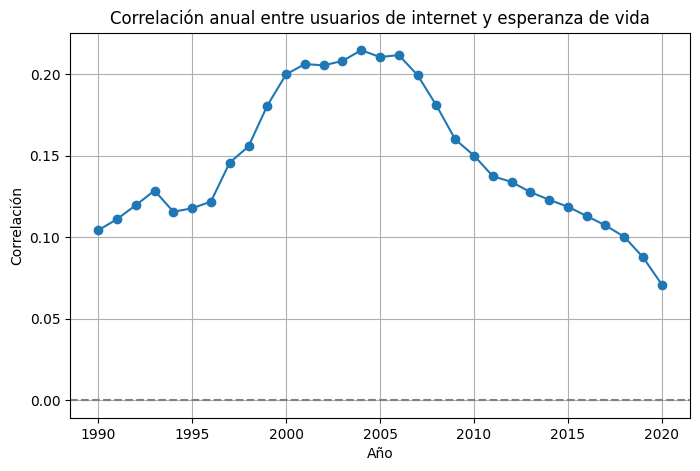

[('Singapore', np.float64(0.9941606988370013)),
 ('Ireland', np.float64(0.993164316039567)),
 ('Australia', np.float64(0.992502431855532)),
 ('Aruba', np.float64(0.9903493020295986)),
 ('Austria', np.float64(0.9895768853400897)),
 ('Slovenia', np.float64(0.9894594626093145)),
 ('New Zealand', np.float64(0.9888598927170654)),
 ('Sao Tome and Principe', np.float64(0.9888475328728858)),
 ('Portugal', np.float64(0.9884704707755273)),
 ('Luxembourg', np.float64(0.9849965666378216)),
 ('Canada', np.float64(0.9837886194922789)),
 ('Switzerland', np.float64(0.9818302122068796)),
 ('Uganda', np.float64(0.9803499936272693)),
 ('Belgium', np.float64(0.979938353830071)),
 ('Hong Kong', np.float64(0.9798861055025382))]

In [27]:
pivot_internet = pivot_internet.copy()  # matriz ya filtrada e interpolada
pivot_life = pivot_life.copy() # la matriz del análisis de esperanza de vida
# Columnas que son años (enteros) en cada pivot
year_cols_int = [c for c in pivot_internet.columns if isinstance(c, (int, np.integer))]
year_cols_life = [c for c in pivot_life.columns if isinstance(c, (int, np.integer))]

# Intersección solo de años
years_common = sorted(set(year_cols_int).intersection(year_cols_life))

print("Años en común:", years_common)

# Nos quedamos solo con esos años en cada matriz
pivot_internet_years = pivot_internet[years_common].copy()
pivot_life_years     = pivot_life[years_common].copy()
pivot_internet = pivot_internet[years_common]
pivot_life = pivot_life[years_common]
countries_common = sorted(list(set(pivot_internet.index).intersection(set(pivot_life.index))))
pivot_internet = pivot_internet.loc[countries_common]
pivot_life = pivot_life.loc[countries_common]

corr_years = {}

for y in years_common:
    corr = np.corrcoef(
        pivot_internet[y],
        pivot_life[y]
    )[0,1]
    corr_years[y] = corr

corr_years

plt.figure(figsize=(8,5))
plt.plot(list(corr_years.keys()), list(corr_years.values()), marker="o")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Correlación anual entre usuarios de internet y esperanza de vida")
plt.xlabel("Año")
plt.ylabel("Correlación")
plt.grid(True)
plt.show()

corr_by_country = {}

for country in countries_common:
    corr = np.corrcoef(
        pivot_internet.loc[country],
        pivot_life.loc[country]
    )[0,1]
    corr_by_country[country] = corr

corr_by_country
sorted(corr_by_country.items(), key=lambda x: x[1], reverse=True)[:15]

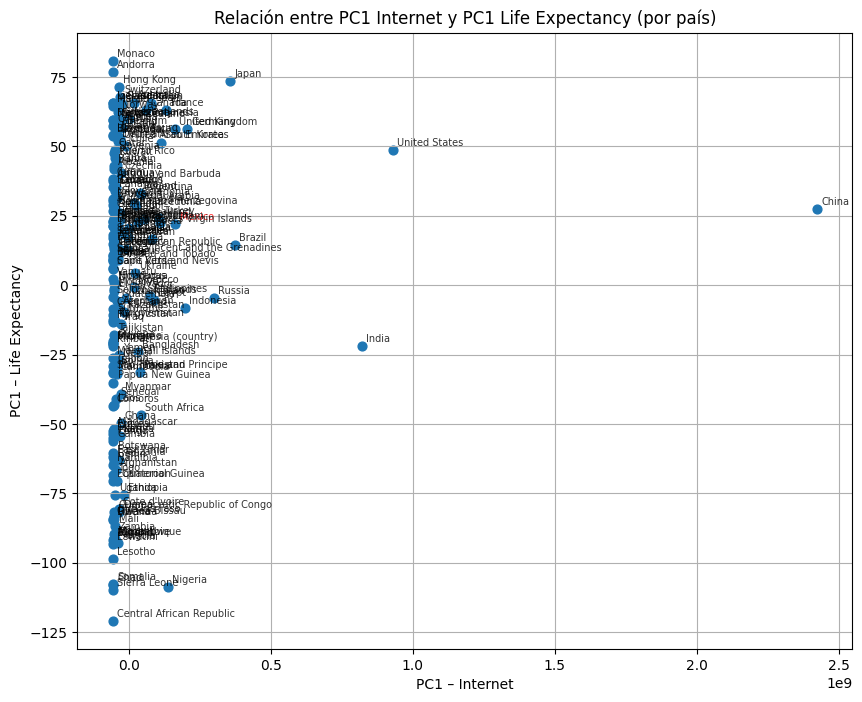

In [31]:
# ===== 1. Extraer PC1 de Internet =====
pca_int = PCA(n_components=1)
pc_int = pca_int.fit_transform(pivot_internet.values)   # (n,1)
pc_int = pc_int.ravel()                                 # convertir a vector (n,)

# ===== 2. Extraer PC1 de Life Expectancy =====
pca_life = PCA(n_components=1)
pc_life = pca_life.fit_transform(pivot_life.values)     # (n,1)
pc_life = pc_life.ravel()                               # convertir a vector (n,)

# ===== 3. Lista de países =====
countries = pivot_internet.index.to_list()

# ===== 4. Gráfica =====
plt.figure(figsize=(10,8))
plt.scatter(pc_int, pc_life, s=40)

# Etiquetar cada punto con el nombre del país
for i, country in enumerate(countries):
  if country=="Mexico":
    plt.annotate(
        country,
        (pc_int[i], pc_life[i]),
        fontsize=7,
        alpha=0.8,
        xytext=(3,3),
        textcoords='offset points',
        color="red"
    )
  else:
    plt.annotate(
        country,
        (pc_int[i], pc_life[i]),
        fontsize=7,
        alpha=0.8,
        xytext=(3,3),
        textcoords='offset points'
    )

plt.xlabel("PC1 – Internet")
plt.ylabel("PC1 – Life Expectancy")
plt.title("Relación entre PC1 Internet y PC1 Life Expectancy (por país)")
plt.grid(True)
plt.show()